In [33]:
%matplotlib inline
import pymysql
import os
import re
import copy
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from lxml import etree
import json
import time
import numpy as np

In [2]:
connection = pymysql.connect(host='127.0.0.1',
                             user='data',
                             password='data',
                             db='mag-new-160205',
                             charset='utf8mb4',
                             port=3306,
                             cursorclass=pymysql.cursors.DictCursor)
cursor = connection.cursor()

In [12]:
cursor.execute("SELECT PaperID FROM Papers WHERE ConferenceSeriesIDMappedToVenueName = '46A05BB0'")
pid = []
for row in cursor.fetchall():
    pid.append(row['PaperID'])
print (len(pid))

12131


In [14]:
st_ref = time.time()
cursor.execute("SELECT PaperID, PaperReferenceID FROM PaperReferences WHERE \
                        PaperID IN (SELECT PaperID FROM Papers WHERE ConferenceSeriesIDMappedToVenueName = '46A05BB0') \
                        AND \
                        PaperReferenceID IN (SELECT PaperID FROM Papers WHERE ConferenceSeriesIDMappedToVenueName = '46A05BB0')")
ref_res = cursor.fetchall()
print ("Searching Time: %.3f" % (time.time() - st_ref))
print (len(ref_res))


Searching Time: 45.800
6408


In [17]:
ref = []
for row in ref_res:
    ref.append((row['PaperID'], row['PaperReferenceID']))
print (ref)


[('5DBAF5D6', '0613A667'), ('826FEE60', '05DA3D56'), ('84D70782', '05DA3D56'), ('18D88DAE', '05DA3D56'), ('6DF32A33', '05DA3D56'), ('5ED7A582', '5C301625'), ('7F568195', '6470C312'), ('83B456B1', '7EDB48DC'), ('02CC9EC0', '6C998ABE'), ('03E3939B', '03E3939B'), ('80F2328A', '0B862DC9'), ('821E3C4C', '7EA40768'), ('5972DBC4', '7EA40768'), ('8179A25A', '07F880BE'), ('80417171', '07F880BE'), ('0BE4EEB3', '07EAFB5C'), ('7EBE3BDA', '7DF75B34'), ('5A0F96AD', '78FA7756'), ('5F8E8EEB', '78FA7756'), ('08C3799C', '08B8DF96'), ('01B54438', '08B8DF96'), ('83B47BEF', '08B8DF96'), ('7D57BB6C', '08B8DF96'), ('0972E7D8', '0972E7D8'), ('7FCF5D6A', '7FC1CC0A'), ('807672AA', '7FC1CC0A'), ('8009057E', '7FC1CC0A'), ('7ED204B6', '7FC1CC0A'), ('0F7B00D4', '7D48558A'), ('7E0FB37C', '7DF6EF54'), ('8165DC7F', '5D9D8AA9'), ('03554AAE', '5D9D8AA9'), ('5D5C3558', '5D9D8AA9'), ('5C5AFD46', '5D9D8AA9'), ('04C3C152', '5D9D8AA9'), ('04998888', '5D9D8AA9'), ('7F9A38D8', '7D5DC133'), ('5F86A7E3', '69A2CC0C'), ('60AD7A05'

In [18]:
def load_result(cursor, container, name):
    for row in cursor.fetchall():
        container.append(row[name])
    return container

In [27]:
auid_link_dict = {}
link_count = 1
st_build = time.time()
for refp, orip in ref:
    oriau = []
    refau = []
    oriyear = []
    refyear = []
    cursor.execute("SELECT AuthorID FROM PaperAuthorAffiliations WHERE PaperID = '%s' "% refp)
    load_result(cursor, refau, 'AuthorID')
    cursor.execute("SELECT PaperPublishYear FROM Papers WHERE PaperID = '%s'" % refp)
    load_result(cursor, refyear, 'PaperPublishYear')
        
    cursor.execute("SELECT AuthorID FROM PaperAuthorAffiliations WHERE PaperID = '%s' "% orip)
    load_result(cursor, oriau, 'AuthorID')
    cursor.execute("SELECT PaperPublishYear FROM Papers WHERE PaperID = '%s'" % orip)
    load_result(cursor, oriyear, 'PaperPublishYear')

    for au in oriau:
        if au not in auid_link_dict.keys():
            auid_link_dict[au] = {}
        for rau in refau:
            if rau not in auid_link_dict[au].keys():
                auid_link_dict[au][rau] = []
            auid_link_dict[au][rau].append((oriyear[0], refyear[0]))
            link_count += 1
print ("build time: %.3f" % (time.time() - st_build))
print ("link count: %d" % link_count)

build time: 14.650
link count: 45716


In [28]:
print (auid_link_dict)

{'7AE0C53D': {'801FA135': [(1994, 1998)], '09586610': [(1994, 1998)]}, '1C2AD895': {'7F0A247A': [(2007, 2009)], '780967CE': [(2007, 2009)], '7FE1DC6A': [(2007, 2009)], '7DF195DC': [(2007, 2009)]}, '7DACA2B9': {'80DCC7AE': [(2012, 2013)], '3CAB9298': [(2012, 2013)], '02D2C557': [(2012, 2013)], '7C16CB32': [(2012, 2013)], '805BF4CE': [(2012, 2013)], '7FA8F055': [(2012, 2013)]}, '15890786': {'457C17C7': [(2008, 2010)], '7682BC83': [(2012, 2014)], '7DE5C33B': [(2012, 2014)], '80240507': [(2008, 2010)], '848B99C1': [(2012, 2015)], '7FBBF220': [(2012, 2015)], '7E82BE51': [(2012, 2014)], '7B39DC3B': [(2012, 2014)], '7DCE21F1': [(2012, 2015)], '736BCB06': [(2008, 2008)]}, '856DCFB3': {'7F680B0B': [(1993, 1994)], '7FE6D109': [(1993, 1994)], '7FC58E16': [(1993, 1994)], '216E60E4': [(1993, 1994)], '7AD55B4F': [(1993, 1994)], '7E00DC60': [(1993, 1994)]}, '77F4D615': {'7E9F7DFB': [(2008, 2010)], '7EFC2E28': [(2008, 2011)], '7DA12DFD': [(2008, 2011)], '39007B00': [(2008, 2011)], '06051588': [(2008, 

In [30]:
outfile = open('data/link_aaai.txt', 'w')
for au in auid_link_dict.keys():
    for rau in auid_link_dict[au].keys():
        outfile.write(au+'\t'+rau+'\t')
        ylen = len(auid_link_dict[au][rau])
        for i in range(ylen-1):
            outfile.write(str(auid_link_dict[au][rau][i][0])+' '+str(auid_link_dict[au][rau][i][1])+'\t')
        outfile.write(str(auid_link_dict[au][rau][ylen-1][0])+' '+str(str(auid_link_dict[au][rau][ylen-1][1]))+'\t'+'\n')

In [31]:
au_set = set()
for au in auid_link_dict.keys():
    au_set.add(au)
    for rau in auid_link_dict[au].keys():
        au_set.add(rau)
print ("author number: %d" % len(au_set))

author number: 7112


In [41]:
au_fos_all = [{}, {}, {}, {}]
au_fos_count = [[],[],[],[]]
for i in range(4):
    for au in au_set:
        cursor.execute("SELECT AuthorFOS.FieldOfStudyIDMappedToKeyword \
                                    FROM AuthorFOS, FieldsOfStudy WHERE \
                                    AuthorFOS.AuthorID = '%s' and FieldsOfStudy.FieldsOfStudyID = AuthorFOS.FieldOfStudyIDMappedToKeyword and \
                                    FieldsOfStudy.FieldsOfStudyLevel = 'L%d' " % (au, i))
        fos = []
        load_result(cursor, fos, 'FieldOfStudyIDMappedToKeyword')
        au_fos_all[i][au]  = fos
        au_fos_count[i].append(len(fos))

InternalError: (1054, "Unknown column 'FieldsOfStudy.FieldOfStudyID' in 'where clause'")

1937


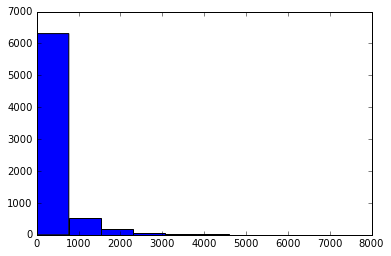

In [38]:
plt.hist(np.array(au_fos_count[0]), bins=10)
plt.hist(np.array(au_fos_count[1]), bins=10)
plt.hist(np.array(au_fos_count[2]), bins=10)
plt.hist(np.array(au_fos_count[3]), bins=10)

In [ ]:
def export_fos(fos_dict, filename):
    for au in fos_dict.keys():
        for 